In [1]:
'''
Ref:Multi-Class Text Classification with Scikit-Learn
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import random
import string
import html
import re
import pickle

from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.exceptions import NotFittedError

/Users/wentingchen/.virtualenvs/insight/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# read file structure and get features and labels(df_paths)

In [2]:
root_dir = '/Users/wentingchen/Documents/Folder_Sophie/' # '/' in the end!!!
data = []
for filename in glob.iglob(root_dir + '**/*', recursive=True):
     data.append(os.path.relpath(filename, root_dir))  
        

In [3]:
random.sample(data,100)

['Research/Hg/HgData_Processing/HgCellwithVaccum/248nmPumped/11-2015V2/173C/485-4.csv',
 'Research/Books/[Peter_Bajorski]_Statistics_for_Imaging,_Optics,_a(BookFi.org).pdf',
 'Research/Hg/HgData_Processing/Hg-two-color-pump/10-05-2016/diff-delay/data1_12.lvm',
 'Research/YI/YI reference/kobayashi1994chiral.pdf',
 'Research/XeI/XeI_Tom/Not_XeI/Optimization/Dig1991/zn248.mat',
 'Research/Hg/HgData_Processing/HgCellwithVaccum/266nmPumped/06-25-2015/162C/60uj-335-3.csv',
 'Research/Hg/HgData_Processing/HgCellwithVaccum/266nmPumped/finaldata/204C/485nm-20uj-5.csv',
 'Research/Hg/HgData_Processing/HgCellwithVaccum/248nmPumped/11-19-2015/298C/380-5.csv',
 'Research/Hg/HgData_Processing/Hg-two-color-pump/oscilloscope/10-12-2016-diffT/1012-266c.csv',
 'Research/Hg/HgData_Processing/Hg-two-color-pump/Hg_TwoColor_Data_before_Oct_2016/09-17-2016/09-17-2016/430-435/test_375.lvm',
 'Research/Hg/HgData_Processing/Hg-two-color-pump/Hg_TwoColor_Data_before_Oct_2016/09-17-2016/09-17-2016/430-435/test_14

In [4]:
# file_names_txt = 'file-path-classifier-data.txt'
# file = open(file_names_txt,'r') 

# data = file.read().split('\n')

In [5]:
data_split = list(map(lambda x: os.path.normpath(x).split(os.sep), data))
data_drop_single = list(filter(lambda x: len(x)>1, data_split)) #change to len(x)>1 since solver needs >=2 classes!!!!

# file name engineering
file_name = list(map(lambda x: x[-1], data_drop_single))

file_name_html = [html.unescape(x) for x in file_name]
file_name_underscore = [x.lower().replace("_", " ") for x in file_name_html]
file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
ps = PorterStemmer()
word_stemmed = [(ps.stem(y) for y in x) for x in file_name_word_split]

word_stemmed_list = [list(x) for x in word_stemmed]
file_name_final = [' '.join(x) for x in word_stemmed_list]        

# file labels engineering
file_labels = list(map(lambda x: x[:-1], data_drop_single))
df_labels = pd.DataFrame(data = file_labels)

In [6]:
df_labels.shape

(16404, 9)

In [7]:
min(5,df_labels.shape[1])

5

In [8]:
df_paths = pd.DataFrame(data = df_labels[0])


# for i in range(1, df_labels.shape[1]):
#     df_paths[i] = df_labels[i]

# change to level depths limit 5:
depth_limit = 5
for i in range(1, min(depth_limit,df_labels.shape[1]) ):
    df_paths[i] = df_labels[i]


    df_paths.loc[pd.notna(df_labels[i]), i] = df_paths[i-1].map(str) + '/' + df_paths[i]
    
df_paths.replace('None', np.nan, inplace=True)
df_paths[-1] = 'dummy'
df_paths = df_paths.astype('category', copy = False)

In [9]:
df_paths.sample(20)

,0,1,2,3,4,-1
16077,CS,CS/Udacity,CS/Udacity/DS_Nanodegree,CS/Udacity/DS_Nanodegree/DSND_Term1-master,CS/Udacity/DS_Nanodegree/DSND_Term1-master/les...,dummy
2517,Research,Research/YI,Research/YI/YI Data,Research/YI/YI Data/Jan 18,Research/YI/YI Data/Jan 18/4400-4650 diffT,dummy
897,Research,Research/XeI,Research/XeI/XeI_Tom,Research/XeI/XeI_Tom/Not_XeI,Research/XeI/XeI_Tom/Not_XeI/Xe2FreeFree,dummy
13691,pictures,pictures/vocation,pictures/vocation/09-19-2016-Indianapolis-IN,NaN,NaN,dummy
8946,Research,Research/Hg,Research/Hg/HgData_Processing,Research/Hg/HgData_Processing/Hg-two-color-pump,Research/Hg/HgData_Processing/Hg-two-color-pum...,dummy
435,Research,Research/XeI,Research/XeI/XeI_Tom,Research/XeI/XeI_Tom/Not_XeI,Research/XeI/XeI_Tom/Not_XeI/Optimization,dummy
11001,Research,Research/Hg,Research/Hg/HgData_Processing,Research/Hg/HgData_Processing/Hg-two-color-pump,Research/Hg/HgData_Processing/Hg-two-color-pum...,dummy
971,Research,Research/XeI,Research/XeI/XeI_Tom,Research/XeI/XeI_Tom/Not_XeI,Research/XeI/XeI_Tom/Not_XeI/Xe2FreeFree,dummy
1376,Research,Research/XeI,Research/XeI/XeI_SpectralSimulations,Research/XeI/XeI_SpectralSimulations/XeI_FayeShen,Research/XeI/XeI_SpectralSimulations/XeI_FayeS...,dummy
10258,Research,Research/Hg,Research/Hg/HgData_Processing,Research/Hg/HgData_Processing/Hg-two-color-pump,Research/Hg/HgData_Processing/Hg-two-color-pum...,dummy


In [10]:
random.sample(file_name,20)

['V1',
 '271-14.csv',
 'output_18_17.png',
 '5_2u.fig',
 '485-2.csv',
 'data_75.lvm',
 'data_175.lvm',
 'data_361.lvm',
 'test_081.lvm',
 'IMG_20170912_122606.jpg',
 'bootstrap-reboot.css.map',
 'test_456.lvm',
 'energymeter_3.lvm',
 'PhysRevA.76.032706Long-range dispersion interactions. II. Alkali-metal and rare-gas atom.pdf',
 '485-2.csv',
 'IMG_5108.JPG',
 'sequence-to-sequence-inference-decoder.png',
 '335nm-200uj-2.csv',
 'test_012.lvm',
 'test_1480.lvm']

# file name engineering

In [11]:
def file_name_processing(file_name):
    

    file_name_html = [html.unescape(x) for x in file_name]
    print(file_name_html)
    file_name_underscore = [x.lower().replace("_", " ") for x in file_name_html]
    print(file_name_underscore)
    file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
    print(file_name_word_split)
    ps = PorterStemmer()
    word_stemmed = [(ps.stem(y) for y in x) for x in file_name_word_split]
    word_stemmed_list = [list(x) for x in word_stemmed]
    
    print(word_stemmed_list)
    file_name_final = [' '.join(x) for x in word_stemmed_list]    
    print(file_name_final)
    
    count_vect = pickle.load(open('count_vect', 'rb'))

    file_name_vect = count_vect.transform(file_name_final)
    
    print(file_name_vect)
    
#     print(count_vect.get_feature_names())
#     print(count_vect.get_stop_words())

In [12]:
name_example=['CP-2006-Theoretical-potential-energy-surfaces for excited mercury trimers.pdf']
file_name_processing(name_example)

['CP-2006-Theoretical-potential-energy-surfaces for excited mercury trimers.pdf']
['cp-2006-theoretical-potential-energy-surfaces for excited mercury trimers.pdf']
[['cp', '2006', 'theoretical', 'potential', 'energy', 'surfaces', 'for', 'excited', 'mercury', 'trimers', 'pdf']]
[['cp', '2006', 'theoret', 'potenti', 'energi', 'surfac', 'for', 'excit', 'mercuri', 'trimer', 'pdf']]
['cp 2006 theoret potenti energi surfac for excit mercuri trimer pdf']
  (0, 141)	1
  (0, 555)	1
  (0, 695)	1
  (0, 707)	1
  (0, 708)	1
  (0, 848)	1
  (0, 914)	1
  (0, 928)	1
  (0, 929)	1
  (0, 1023)	1
  (0, 1061)	1


In [13]:
name_example=['JPD 2006 Optical emission studies of the mercury plasma generated by the fundamental, second and third harmonics of a Nd  YAG laser.pdf']

file_name_processing(name_example)

['JPD 2006 Optical emission studies of the mercury plasma generated by the fundamental, second and third harmonics of a Nd \u2009YAG laser.pdf']
['jpd 2006 optical emission studies of the mercury plasma generated by the fundamental, second and third harmonics of a nd \u2009yag laser.pdf']
[['jpd', '2006', 'optical', 'emission', 'studies', 'of', 'the', 'mercury', 'plasma', 'generated', 'by', 'the', 'fundamental', 'second', 'and', 'third', 'harmonics', 'of', 'a', 'nd', 'yag', 'laser', 'pdf']]
[['jpd', '2006', 'optic', 'emiss', 'studi', 'of', 'the', 'mercuri', 'plasma', 'gener', 'by', 'the', 'fundament', 'second', 'and', 'third', 'harmon', 'of', 'a', 'nd', 'yag', 'laser', 'pdf']]
['jpd 2006 optic emiss studi of the mercuri plasma gener by the fundament second and third harmon of a nd yag laser pdf']
  (0, 141)	1
  (0, 691)	1
  (0, 732)	1
  (0, 736)	1
  (0, 819)	1
  (0, 821)	1
  (0, 848)	1
  (0, 893)	1
  (0, 914)	1
  (0, 1007)	1
  (0, 1118)	1


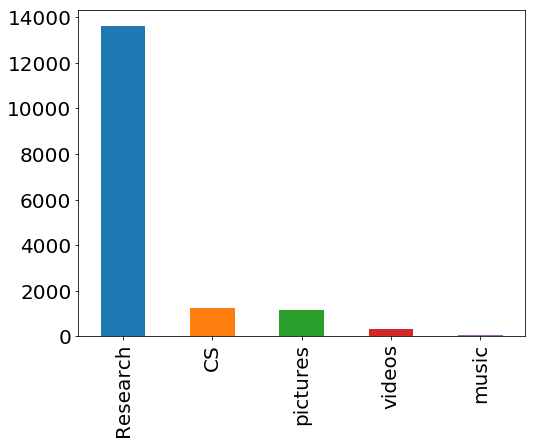

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_paths[0].value_counts().plot.bar(ylim=0)
plt.tick_params(which='major', labelsize=20)
plt.show()

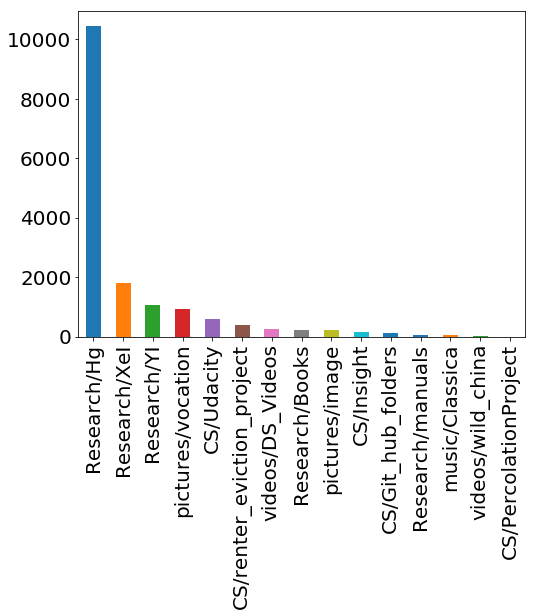

In [15]:
fig = plt.figure(figsize=(8,6))
df_paths.loc[:,1].value_counts().plot.bar(ylim=0)
plt.tick_params(which='major', labelsize=20)
plt.show()

In [16]:
df_paths.shape

(16404, 6)

In [17]:
df_paths[0].value_counts()


Research    13632
CS           1262
pictures     1152
videos        307
music          51
Name: 0, dtype: int64

In [18]:
type(_)

pandas.core.series.Series

In [19]:
df_paths[0].value_counts().tolist()

[13632, 1262, 1152, 307, 51]

In [20]:
df_paths[0].value_counts().index

CategoricalIndex(['Research', 'CS', 'pictures', 'videos', 'music'], categories=['CS', 'Research', 'music', 'pictures', 'videos'], ordered=False, dtype='category')

# Train the model

In [39]:
def Hierarchical_train(file_name_final, df_paths):
    
#     count_vect = CountVectorizer(min_df=8, encoding='latin-1', \
#                     ngram_range=(1, 2), stop_words='english')

#     X_train_counts = count_vect.fit_transform(file_name_final)
#     #features = X_train_counts.toarray()
    
# # works better without tf-idf
# #     tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

# #     X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# #     features = X_train_tfidf.toarray()

    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=8, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    features = tfidf.fit_transform(file_name_final).toarray()


    depth = df_paths.shape[1]
    folder_each_level = [df_paths[x].cat.categories.tolist() for x in range(-1,df_paths.shape[1]-1)]



    clf = [[LogisticRegression(random_state = 0, multi_class='multinomial',solver='newton-cg') for _ in range(len(folder_each_level[x]))] \
           for x in range(len(folder_each_level))]

    for i in range(len(folder_each_level)-1):
        for j in range(len(folder_each_level[i])):

            # input control
            ind = ((df_paths[i-1] == folder_each_level[i][j]) & (df_paths[i].notna())) # remove NAN paths at the same time          

            # category / labels control: next col of df_paths
            features_level = features[ind] # just pick the corresponding entries
            labels_level = np.asarray(df_paths[i][ind], dtype="str")
            
            if len(np.unique(labels_level)) > 1 and len(labels_level)>5:
                clf[i][j] = LogisticRegression(random_state = 0)
                clf[i][j].fit(features_level, labels_level)
    
    pickle.dump(clf, open('clf_folder_picker', 'wb'))
    pickle.dump(folder_each_level, open('folder_each_level', 'wb'))
    #pickle.dump(count_vect, open('count_vect', 'wb'))
    pickle.dump(tfidf, open('tfidf', 'wb'))
    

# sklearn, logistic regression:
multi_calss default: one vs rest 


In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross- entropy loss if the ‘multi_class’ option is set to ‘multinomial’. (Currently the ‘multinomial’ option is supported only by the ‘lbfgs’, ‘sag’ and ‘newton-cg’ solvers.)


multi_class : str, {‘ovr’, ‘multinomial’, ‘auto’}, default: ‘ovr’
If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.

In [36]:
LogisticRegression(random_state=0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
LogisticRegression(random_state = 0, multi_class='multinomial')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
LogisticRegression(random_state = 0, multi_class='multinomial',solver='newton-cg')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

# Predict

In [40]:
def Hierarchical_predict(file_names_input, prob_threshold):
    # file_names_input should be an array
#     clf = clf
#     count_vect = count_vect
    
    prob_threshold = prob_threshold
    
    
    clf = pickle.load(open('clf_folder_picker', 'rb'))
    folder_each_level = pickle.load(open('folder_each_level', 'rb'))
    #count_vect = pickle.load(open('count_vect', 'rb'))
    tfidf = pickle.load(open('tfidf','rb'))
    
    file_name_html = [html.unescape(x) for x in file_names_input]
    file_name_underscore = [x.lower().replace("_", " ") for x in file_name_html]
    file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
    ps = PorterStemmer()
    word_stemmed = [(ps.stem(y) for y in x) for x in file_name_word_split]

    word_stemmed_list = [list(x) for x in word_stemmed]
    file_name_final = [' '.join(x) for x in word_stemmed_list]   
    
    
    

    preds = []
    for file_name_input in file_name_final:
        
        #vect_name = count_vect.transform([file_name_input])
        vect_name = tfidf.transform([file_name_input])
        y_pred =  ['' for _ in range(len(folder_each_level)-1)]
        prob = [0 for _ in range(len(folder_each_level)-1)]
        prob_total = 1

        current_folder = 'dummy'
        for i in range(len(folder_each_level)-1):
            for j in range(len(folder_each_level[i])):
#                 print(i,j)

                if current_folder != folder_each_level[i][j]: #make sure it is the right subfolder
                    continue

#                 print('folder_each_level:',folder_each_level[i][j])
#                 print('current_folder:', current_folder)

                try:
                    clf[i][j].predict(vect_name)
                except NotFittedError as e:
                    #print('error')
                    break
                    
                y_pred[i] = clf[i][j].predict(vect_name)[0]
                current_folder = y_pred[i]
                prob[i] = np.max(clf[i][j].predict_proba(vect_name))
                prob_total *= prob[i]

#                     print(y_pred[i], prob[i], prob_total,'\n')


    
            if prob_total < prob_threshold or y_pred[i] == '':
                break
       
        # if i > 0 and back up a level if prob_total < prob_threshold:
        if (i > 0) and ((prob_total < prob_threshold) or (y_pred[i] == '')):
            pred_folder = y_pred[i-1] 
            level = i
        else:
            pred_folder = y_pred[i]
            level = i+1
        
        # when there is no pretrained clf available at this level
        if pred_folder == '':
            #print(i, j, current_folder,'\n', y_pred[i-2], y_pred[i-1])
            pred_folder = current_folder
        preds.append((pred_folder, level))
        
        
    return preds
    

In [41]:
df_paths.shape[1]

6

# Evaluation


## same path, not necessarily same folder

In [42]:
from collections import defaultdict

def Hierarchical_auc(pred_folder, df_paths):
    count_total = len(pred_folder)
    count_right_path = 0
    count_right_level = 0
    #count_close_level = 0
    
    level_diff_max = df_paths.shape[1] - 1
    count_diff = [0 for _ in range(level_diff_max)]
    
    file_folder_labels = pd.DataFrame(data = df_paths.count(axis=1)-1, columns=['level'])
    file_folder_labels['labels'] = [set(df_paths.iloc[x,:]) for x in range(df_paths.shape[0])]

    d = defaultdict(int)

    for i in range(count_total):
        if pred_folder[i][0] in file_folder_labels.iloc[i, 1]:
            count_right_path +=1
            d[pred_folder[i][1]] += 1
            
            if pred_folder[i][1] == file_folder_labels.iloc[i, 0]:
                count_right_level +=1
                
            for j in range(level_diff_max):
                if j == 0 :
                    if pred_folder[i][1] == file_folder_labels.iloc[i, 0]:
                        count_diff[j] +=1
                else:
                    if pred_folder[i][1] == file_folder_labels.iloc[i, 0]-j:# \or pred_folder[i][1] == file_folder_labels.iloc[i, 0]+j:
                        count_diff[j] +=1
                
            
            
                


    b = defaultdict(int)
    for i in d.keys():
        b[i] = round(d[i]/count_total,3)
    print(b.items())
    
    count_list = [count_right_path/count_total, count_right_level/count_total]
    count_ratio = [round(x,3) for x in count_list]
    print('Ratio of count_right_path', 'Ratio of count_right_level', count_ratio)

    
    print('count_diff\n',[round(x/count_total,3) for x in count_diff])
    return count_ratio[0], b.items(), count_diff
    

In [43]:
df_paths.shape

(16404, 6)

# Cross - Validation

In [44]:
file_name_final[:10]

['xei',
 'book',
 'yi',
 'manual',
 'hg',
 'refer and previou work',
 "shen' work data",
 'xei tom',
 'xei spectralsimul',
 'transit intens']

In [45]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True, random_state=42)

kf.get_n_splits(file_name_final)

# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)

i = 0 
right_path_ratio = [0 for _ in range (10)]
levels_distri = [{} for _ in range (10)]
levels_diff = [[] for _ in range (10)]
for train_index, test_index in kf.split(file_name_final):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = np.array(file_name_final)[train_index], np.array(file_name_final)[test_index]
    y_train, y_test = df_paths.iloc[train_index,:], df_paths.iloc[test_index,:]
    
    Hierarchical_train(X_train, y_train)
    prob_threshold = 0.62
#     print('train:')
#     preds = Hierarchical_predict(X_train, prob_threshold)
#     Hierarchical_auc(preds, y_train)
    
    print('test')
    preds_test = Hierarchical_predict(X_test, prob_threshold)
    right_path_ratio[i], levels_distri[i], levels_diff[i] = Hierarchical_auc(preds_test, y_test)
    print('\n')
    i += 1

test
dict_items([(1, 0.158), (2, 0.082), (3, 0.116), (4, 0.206), (5, 0.248)])
Ratio of count_right_path Ratio of count_right_level [0.809, 0.306]
count_diff
 [0.306, 0.249, 0.109, 0.055, 0.09]


test
dict_items([(2, 0.083), (1, 0.16), (3, 0.118), (4, 0.241), (5, 0.232)])
Ratio of count_right_path Ratio of count_right_level [0.833, 0.284]
count_diff
 [0.284, 0.293, 0.11, 0.066, 0.08]


test
dict_items([(2, 0.073), (1, 0.159), (3, 0.127), (4, 0.203), (5, 0.246)])
Ratio of count_right_path Ratio of count_right_level [0.808, 0.312]
count_diff
 [0.312, 0.239, 0.097, 0.076, 0.084]


test
dict_items([(2, 0.087), (1, 0.174), (3, 0.108), (4, 0.228), (5, 0.239)])
Ratio of count_right_path Ratio of count_right_level [0.836, 0.293]
count_diff
 [0.293, 0.278, 0.109, 0.069, 0.086]


test
dict_items([(1, 0.159), (2, 0.088), (3, 0.127), (4, 0.229), (5, 0.211)])
Ratio of count_right_path Ratio of count_right_level [0.815, 0.27]
count_diff
 [0.27, 0.282, 0.113, 0.072, 0.079]


test
dict_items([(1, 0.176

In [135]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True, random_state=42)

kf.get_n_splits(file_name_final)

# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)

i = 0 
right_path_ratio = [0 for _ in range (10)]
levels_distri = [{} for _ in range (10)]
levels_diff = [[] for _ in range (10)]
for train_index, test_index in kf.split(file_name_final):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = np.array(file_name_final)[train_index], np.array(file_name_final)[test_index]
    y_train, y_test = df_paths.iloc[train_index,:], df_paths.iloc[test_index,:]
    
    Hierarchical_train(X_train, y_train)
    prob_threshold = 0.62
#     print('train:')
#     preds = Hierarchical_predict(X_train, prob_threshold)
#     Hierarchical_auc(preds, y_train)
    
    print('test')
    preds_test = Hierarchical_predict(X_test, prob_threshold)
    right_path_ratio[i], levels_distri[i], levels_diff[i] = Hierarchical_auc(preds_test, y_test)
    print('\n')
    i += 1

test
dict_items([(1, 0.158), (2, 0.082), (3, 0.116), (4, 0.206), (5, 0.248)])
Ratio of count_right_path Ratio of count_right_level [0.809, 0.306]
count_diff
 [0.306, 0.249, 0.109, 0.055, 0.09]


test
dict_items([(2, 0.083), (1, 0.16), (3, 0.118), (4, 0.241), (5, 0.232)])
Ratio of count_right_path Ratio of count_right_level [0.833, 0.284]
count_diff
 [0.284, 0.293, 0.11, 0.066, 0.08]


test
dict_items([(2, 0.073), (1, 0.159), (3, 0.127), (4, 0.203), (5, 0.246)])
Ratio of count_right_path Ratio of count_right_level [0.808, 0.312]
count_diff
 [0.312, 0.239, 0.097, 0.076, 0.084]


test
dict_items([(2, 0.087), (1, 0.174), (3, 0.108), (4, 0.228), (5, 0.239)])
Ratio of count_right_path Ratio of count_right_level [0.836, 0.293]
count_diff
 [0.293, 0.278, 0.109, 0.069, 0.086]


test
dict_items([(1, 0.159), (2, 0.088), (3, 0.127), (4, 0.229), (5, 0.211)])
Ratio of count_right_path Ratio of count_right_level [0.815, 0.27]
count_diff
 [0.27, 0.282, 0.113, 0.072, 0.079]


test
dict_items([(1, 0.176

In [ ]:
right_path_ratio, levels_distri[i], levels_diff[i]

In [136]:
right_path_ratio

[0.809, 0.833, 0.808, 0.836, 0.815, 0.825, 0.838, 0.816, 0.808, 0.831]

In [147]:
np.sum(right_path_ratio)/10

0.8219

In [138]:
levels_distri

[dict_items([(1, 0.158), (2, 0.082), (3, 0.116), (4, 0.206), (5, 0.248)]),
 dict_items([(2, 0.083), (1, 0.16), (3, 0.118), (4, 0.241), (5, 0.232)]),
 dict_items([(2, 0.073), (1, 0.159), (3, 0.127), (4, 0.203), (5, 0.246)]),
 dict_items([(2, 0.087), (1, 0.174), (3, 0.108), (4, 0.228), (5, 0.239)]),
 dict_items([(1, 0.159), (2, 0.088), (3, 0.127), (4, 0.229), (5, 0.211)]),
 dict_items([(1, 0.176), (3, 0.146), (5, 0.23), (2, 0.065), (4, 0.207)]),
 dict_items([(1, 0.175), (2, 0.077), (4, 0.223), (3, 0.127), (5, 0.236)]),
 dict_items([(1, 0.152), (2, 0.081), (3, 0.135), (4, 0.214), (5, 0.234)]),
 dict_items([(1, 0.16), (2, 0.075), (3, 0.12), (5, 0.23), (4, 0.223)]),
 dict_items([(1, 0.155), (2, 0.07), (3, 0.119), (4, 0.244), (5, 0.244)])]

In [157]:
for dist in levels_distri:
    d = defaultdict(int)
    for m in dist:
        #print(m)
        d[m[0]] += m[1]
print(d)    

defaultdict(<class 'int'>, {1: 0.155, 2: 0.07, 3: 0.119, 4: 0.244, 5: 0.244})


In [151]:
for k in dict_items([(1, 0.158), (2, 0.082), (3, 0.116), (4, 0.206), (5, 0.248)]):
    print(k)

NameError: name 'dict_items' is not defined

In [137]:
levels_diff

[[502, 409, 179, 90, 148],
 [466, 481, 180, 108, 132],
 [512, 393, 159, 124, 138],
 [481, 457, 179, 114, 141],
 [442, 462, 186, 118, 129],
 [487, 414, 186, 106, 160],
 [496, 445, 170, 116, 147],
 [491, 441, 172, 120, 115],
 [469, 441, 194, 98, 123],
 [484, 465, 175, 111, 128]]

In [142]:
level_diff_ratio = []
for lvl_diff in levels_diff:
    print(np.sum(lvl_diff))
    level_diff_ratio.append(np.array(lvl_diff )/np.sum(lvl_diff))

1328
1367
1326
1372
1337
1353
1374
1339
1325
1363


In [143]:
level_diff_ratio

[array([0.37801205, 0.30798193, 0.13478916, 0.06777108, 0.11144578]),
 array([0.34089247, 0.3518654 , 0.1316752 , 0.07900512, 0.09656181]),
 array([0.38612368, 0.29638009, 0.1199095 , 0.09351433, 0.1040724 ]),
 array([0.35058309, 0.33309038, 0.13046647, 0.08309038, 0.10276968]),
 array([0.33059088, 0.34554974, 0.13911743, 0.08825729, 0.09648467]),
 array([0.35994087, 0.3059867 , 0.13747228, 0.07834442, 0.11825573]),
 array([0.36098981, 0.32387191, 0.12372635, 0.08442504, 0.1069869 ]),
 array([0.36669156, 0.32935026, 0.12845407, 0.08961912, 0.08588499]),
 array([0.35396226, 0.33283019, 0.14641509, 0.07396226, 0.09283019]),
 array([0.35509905, 0.34115921, 0.12839325, 0.081438  , 0.09391049])]

In [146]:
np.average(level_diff_ratio, axis=0)

array([0.35828857, 0.32680658, 0.13204188, 0.0819427 , 0.10092026])

## train split data, vectorize features

In [76]:
X_train, X_test, y_train, y_test = train_test_split(file_name_final, df_paths, \
                                                    test_size=0.1, random_state = 42)

## train predict compare acccuracy

In [95]:
Hierarchical_train(X_train, y_train)

In [115]:
prob_threshold = 0.62
preds = Hierarchical_predict(X_train, prob_threshold)

In [116]:
Hierarchical_auc(preds, y_train)

dict_items([(5, 0.236), (4, 0.223), (2, 0.08), (1, 0.159), (3, 0.132)])
Ratio of count_right_path Ratio of count_right_level [0.83, 0.296]
count_diff
 [0.296, 0.273, 0.115, 0.066, 0.08]


In [117]:
preds_test = Hierarchical_predict(X_test, prob_threshold)

Hierarchical_auc(preds_test, y_test)

dict_items([(4, 0.206), (5, 0.248), (2, 0.082), (3, 0.116), (1, 0.158)])
Ratio of count_right_path Ratio of count_right_level [0.809, 0.306]
count_diff
 [0.306, 0.249, 0.109, 0.055, 0.09]


In [99]:
from functools import reduce
reduce((lambda x, y: x + y), [0.244, 0.152, 0.138, 0.127, 0.086, 0.07, 0.068, 0.028, 0.003])

0.916

In [82]:
reduce((lambda x, y: x + y), [0.086, 0.07, 0.068, 0.028,0.003])

0.255

In [124]:
preds[0][0]

'Research/Hg/HgData_Processing/HgCellwithVaccum/248nmPumped'

In [125]:
# for i, pred in enumerate(preds):
#     print(pred)
#     #print(X_train[i],'\n')

In [100]:
t = preds_test
t.sort(key=lambda x: x[1])

In [105]:
for i,tt in enumerate(t):
    print(X_test[i],tt)

data 340 lvm ('Research', 1)
test 1240 lvm ('Research', 1)
demograph statist by zip code csv ('Research', 1)
data1 12 lvm ('Research', 1)
hene glue 20x fit ('Research', 1)
data 214 lvm ('Research', 1)
test 329 lvm ('Research', 1)
time relat png ('Research', 1)
img 5464 jpg ('Research', 1)
data 16 lvm ('CS', 1)
dissoci energi and long rang potenti of diatom molecul from vibrat space of higher level pdf ('Research', 1)
data 300 lvm ('Research', 1)
data1 96 lvm ('Research', 1)
500c 335 3 csv ('pictures', 1)
271 13 csv ('Research', 1)
data 389 lvm ('Research', 1)
data1 17 lvm ('Research', 1)
test 286 lvm ('Research', 1)
485 2 csv ('Research', 1)
test 531 lvm ('Research', 1)
3 oum csv ('Research', 1)
jonin1g a bmp ('music', 1)
the extern heavi atom effect theori of spin orbit coupl of alkali and nobl pdf ('Research', 1)
2 gradient descent math mp4 ('CS', 1)
p larg eerf 4b120008adeb5c40 jpg ('Research', 1)
266nm pump waveform3 png ('Research', 1)
data 10 lvm ('Research', 1)
yi3 1750 to 3130a

test 187 lvm ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
335c ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
271 3 csv ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
rise time for both wavelength opj ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
img 5424 jpg ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
data1 92 lvm ('Research/Hg/HgData_Processing/HgCellwithVaccum', 4)
img 5407 jpg ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
test 1418 lvm ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
smsspamcollect ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
predict model py ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
485nm 20uj 2 csv ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
j 220 jpg ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
520 5 csv ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
renter evict story2 png ('Research/Hg/HgData_Processing/Hg-two-color-pump', 4)
random project and ica 

# accumulated prob_total version

# right path & folder rate

In [127]:
# accumulated prob_total version with tf-idf

for prob_threshold in np.linspace(0,1,11):
    print(prob_threshold)
    print('train_set:')
    preds = Hierarchical_predict(X_train, prob_threshold)

    Hierarchical_auc(preds, y_train)
    print('\n')
    print('test_set')
    preds_test = Hierarchical_predict(X_test,prob_threshold)

    Hierarchical_auc(preds_test, y_test)
    print('\n\n')

0.0
train_set:
dict_items([(5, 0.412), (3, 0.039), (4, 0.019), (2, 0.011), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.484, 0.471]
count_diff
 [0.471, 0.012, 0.002, 0.0, 0.0]


test_set
dict_items([(5, 0.377), (3, 0.033), (2, 0.015), (4, 0.015), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.442, 0.428]
count_diff
 [0.428, 0.014, 0.001, 0.0, 0.0]



0.1
train_set:
dict_items([(5, 0.407), (3, 0.083), (2, 0.012), (4, 0.024), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.53, 0.489]
count_diff
 [0.489, 0.033, 0.008, 0.0, 0.0]


test_set
dict_items([(5, 0.374), (3, 0.08), (2, 0.015), (4, 0.018), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.489, 0.445]
count_diff
 [0.445, 0.035, 0.009, 0.0, 0.0]



0.2
train_set:
dict_items([(5, 0.391), (3, 0.098), (4, 0.05), (2, 0.022), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.564, 0.471]
count_diff
 [0.471, 0.072, 0.02, 0.0, 0.0]


test

In [37]:
# accumulated prob_total version without tfidf

for prob_threshold in np.linspace(0,1,11):
    print(prob_threshold)
    print('train_set:')
    preds = Hierarchical_predict(X_train, prob_threshold)

    Hierarchical_auc(preds, y_train)
    print('\n')
    print('test_set')
    preds_test = Hierarchical_predict(X_test,prob_threshold)

    Hierarchical_auc(preds_test, y_test)
    print('\n\n')

0.0
train_set:
dict_items([(5, 0.419), (3, 0.046), (4, 0.026), (2, 0.007), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.502, 0.485]
count_diff
 [0.485, 0.015, 0.002, 0.0, 0.0]


test_set
dict_items([(5, 0.38), (3, 0.036), (2, 0.011), (4, 0.022), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.452, 0.435]
count_diff
 [0.435, 0.016, 0.001, 0.0, 0.0]



0.1
train_set:
dict_items([(5, 0.415), (3, 0.06), (2, 0.008), (4, 0.032), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.518, 0.484]
count_diff
 [0.484, 0.029, 0.006, 0.0, 0.0]


test_set
dict_items([(5, 0.376), (3, 0.053), (2, 0.011), (4, 0.029), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.472, 0.436]
count_diff
 [0.436, 0.032, 0.004, 0.0, 0.0]



0.2
train_set:
dict_items([(5, 0.407), (4, 0.041), (3, 0.099), (2, 0.019), (1, 0.003)])
Ratio of count_right_path Ratio of count_right_level [0.568, 0.498]
count_diff
 [0.498, 0.047, 0.021, 0.003, 0.0]




# threhold pick:

p = 0.8 
test_set
dict_items([(4, 0.2), (1, 0.2), (5, 0.248), (2, 0.091), (3, 0.078)])


Ratio of count_right_path Ratio of count_right_level [0.818, 0.289]


count_diff
 [0.289, 0.257, 0.088, 0.061, 0.123]

In [76]:
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# confustion matrix:

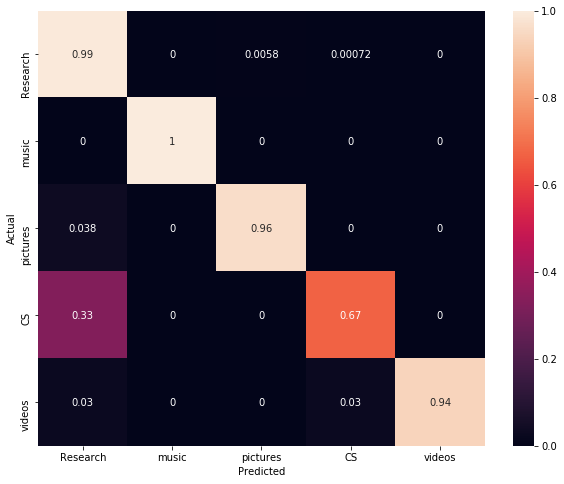

In [138]:
# 
count_vect = CountVectorizer(min_df=8, encoding='latin-1', \
                ngram_range=(1, 2), stop_words='english')

X_train_counts = count_vect.fit_transform(file_name_final)
features = X_train_counts.toarray()


categ_labels = list(df_paths[0].unique())


model = LogisticRegression(random_state = 0)
X_train, X_test, y_train, y_test, indices_train, indices_test = \
train_test_split(features, df_paths[0], df_paths.index, test_size=0.1, random_state=42)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)


from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_test, y_pred,labels=categ_labels)
fig, ax = plt.subplots(figsize=(10,8))

#if normalize:
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        
#sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=categ_labels, yticklabels=categ_labels)
sns.heatmap(conf_mat, annot=True,xticklabels=categ_labels, yticklabels=categ_labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [139]:
conf_mat 

array([[9.93478261e-01, 0.00000000e+00, 5.79710145e-03, 7.24637681e-04,
        0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [3.80952381e-02, 0.00000000e+00, 9.61904762e-01, 0.00000000e+00,
        0.00000000e+00],
       [3.30508475e-01, 0.00000000e+00, 0.00000000e+00, 6.69491525e-01,
        0.00000000e+00],
       [3.03030303e-02, 0.00000000e+00, 0.00000000e+00, 3.03030303e-02,
        9.39393939e-01]])

**Hierarchical Classification**

In the **top-down approach**, in the training phase, the class hierarchy is processed one
level at a time, producing one or more classifiers for each class level. In the test phase,
each example is classified in a top-down fashion, as follows. 

First, the test example is assigned to one or more classes by the first-level classifier(s). 

Then the second level classifier(s) will assign to this example one or more sub-classes of the class(es) predicted
at the first level, and so on, until the example’s class(es) is(are) predicted at the deepest
possible level.

In order to produce a hierarchical set of classifiers in the top-down approach, we can
either train a single classifier per class level or train multiple classifiers per level. In the
former case, we use a multi-class classification algorithm. Thus, at each class level, we
build a classifier that predicts the class(es) of an example at that level. 

**Plan:**

At each node, build a classifier? And then save all the calssifiers?

# NO-hierarchical part

In [123]:
# same as the part in the begining of this notebook

# data_split = list(map(lambda x: os.path.normpath(x).split(os.sep), data))
# data_drop_single = list(filter(lambda x: len(x)>1, data_split)) #change to len(x)>1 since solver needs >=2 classes!!!!
# file_name = list(map(lambda x: x[-1], data_drop_single))
# file_name_html = [html.unescape(x) for x in file_name]
# file_name_underscore = [x.lower().replace("_", " ") for x in file_name_html]
# file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
# file_name_final = [' '.join(x) for x in file_name_word_split]        

# #file_names_col = np.array(file_name_final).reshape(-1,1)


# file_labels = list(map(lambda x: x[:-1], data_drop_single))
# df_labels = pd.DataFrame(data = file_labels)
# df_paths = pd.DataFrame(data = df_labels[0])
# for i in range(1, df_labels.shape[1]):
#     df_paths[i] = df_labels[i]

#     df_paths.loc[pd.notna(df_labels[i]), i] = df_paths[i-1].map(str) + '/' + df_paths[i]
    
# df_paths.replace('None', np.nan, inplace=True)
# df_paths[-1] = 'dummy'
# df_paths = df_paths.astype('category', copy = False)



# feature Vectorizition

In [146]:
len(file_name_final)

16404

In [82]:
random.sample(file_name_final,20)

['yi3 6600 to 7100a time14 jan 2015 18 16 44 mat',
 '485nm 20uj 4 csv',
 'peakexpt mat',
 'renter evict story1 png',
 'data 428 lvm',
 'data 2 lvm',
 '335 4 csv',
 'yi3 2975 to 3060a time04 feb 2015 15 28 21 jpg',
 'test 1500 lvm',
 'sequenc to sequenc implement ipynb',
 '485nm 20uj 3 csv',
 'yi3 2550 to 3550a time02 feb 2015 20 43 47 jpg',
 'data1 124 lvm',
 'img 20170911 123436 jpg',
 'test 354 lvm',
 'img 5432 jpg',
 'page right png',
 'data 6 lvm',
 'data 72 lvm',
 'fbab m']

# equivalent:

In [44]:
# count_vect_all = CountVectorizer(min_df=8, encoding='latin-1', \
#                     ngram_range=(1, 2), stop_words='english')

# #encoding='latin-1',
# X_train_counts = count_vect_all.fit_transform(file_name_final)
# tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# features = X_train_tfidf.toarray()
# labels = df_paths[0]
# features.shape

In [45]:
# chi2 uses tf-idf.get_features

In [46]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=8, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(file_name_final).toarray()
labels = df_paths[0]
cats = df_paths[0].cat.categories.tolist()

In [47]:
features.shape

(16404, 1259)

In [48]:
df_paths[0].unique()

[Research, music, pictures, CS, videos]
Categories (5, object): [Research, music, pictures, CS, videos]

# visualize output label

In [114]:
N = 5
for category_id in sorted(cats):
    
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category_id))
    print("  ** Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  ** Most correlated bigrams:\n. {}\n".format('\n. '.join(bigrams[-N:])))

# 'CS':
  ** Most correlated unigrams:
. evict
. png
. py
. output
. ipynb
  ** Most correlated bigrams:
. 5yr s2301
. solut ipynb
. output 19
. output 18
. output 15

# 'Research':
  ** Most correlated unigrams:
. lvm
. output
. ipynb
. jpg
. img
  ** Most correlated bigrams:
. img 20170909
. img 20170913
. img 20170911
. img 20180114
. img 20170912

# 'music':
  ** Most correlated unigrams:
. 49
. ii
. minor
. concerto
. mp3
  ** Most correlated bigrams:
. 485nm csv
. 200uj csv
. 335nm 200uj
. 485 csv
. 335 csv

# 'pictures':
  ** Most correlated unigrams:
. larg
. 20180114
. 20170912
. jpg
. img
  ** Most correlated bigrams:
. img 20170909
. img 20170913
. img 20170911
. img 20180114
. img 20170912

# 'videos':
  ** Most correlated unigrams:
. en
. lang
. srt
. v1
. mp4
  ** Most correlated bigrams:
. learn l3
. unsupervis learn
. mlnd unsupervis
. en srt
. lang en



In [158]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=8, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(file_name_final).toarray()
labels = df_paths[1]
cats = df_paths[1].cat.categories.tolist()

In [160]:
N = 2
for category_id in cats:
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category_id))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}\n".format('\n. '.join(bigrams[-N:])))

# 'CS/Git_hub_folders':
  . Most correlated unigrams:
. ipynb
. md
  . Most correlated bigrams:
. lab ipynb
. renter evict

# 'CS/Insight':
  . Most correlated unigrams:
. hierarch
. bootstrap
  . Most correlated bigrams:
. 335 csv
. hierarch classif

# 'CS/PercolationProject':
  . Most correlated unigrams:
. pdf
. docx
  . Most correlated bigrams:
. 485 csv
. 335 csv

# 'CS/Udacity':
  . Most correlated unigrams:
. py
. ipynb
  . Most correlated bigrams:
. data csv
. solut ipynb

# 'CS/renter_eviction_project':
  . Most correlated unigrams:
. ac
. output
  . Most correlated bigrams:
. output 19
. output 18

# 'Research/Books':
  . Most correlated unigrams:
. ch
. pdf
  . Most correlated bigrams:
. pure appli
. ch pdf

# 'Research/Hg':
  . Most correlated unigrams:
. jpg
. lvm
  . Most correlated bigrams:
. 485 csv
. 335 csv

# 'Research/XeI':
  . Most correlated unigrams:
. ogg
. mat
  . Most correlated bigrams:
. angstrom csv
. free wvfn

# 'Research/YI':
  . Most correlated unigrams

# Model Selection Based on First Folder

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

# Confusin Matrix

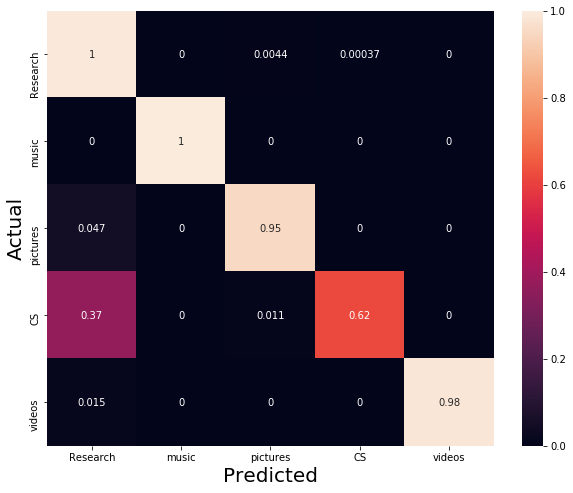

In [138]:
count_vect = CountVectorizer(min_df=8, encoding='latin-1', \
                ngram_range=(1, 2), stop_words='english')

X_train_counts = count_vect.fit_transform(file_name_final)
features = X_train_counts.toarray()


categ_labels = list(df_paths[0].unique())


model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = \
train_test_split(features, df_paths[0], df_paths.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_test, y_pred,labels=categ_labels)
fig, ax = plt.subplots(figsize=(10,8))

#if normalize:
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        
#sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=categ_labels, yticklabels=categ_labels)
sns.heatmap(conf_mat, annot=True,xticklabels=categ_labels, yticklabels=categ_labels)

plt.ylabel('Actual', fontsize = 20)
plt.xlabel('Predicted',fontsize = 20)

ax.xaxis.label.set_size(20)
plt.show()



## fucntion for main folder prediction

In [ ]:
# import pandas as pd
# import numpy as np
# import os
# import glob
# import random
# import string
# import html
# import re
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
# from sklearn.svm import LinearSVC
# import pickle


# def ModelIt(file_name_input, file_path_input):
#     model_train(file_path_input)
#     path_pred = model_predict(file_name_input)
#     return path_pred

# def model_train( file_path_input):

#     if file_path_input == '':
#         file_path_input = os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)) \
#         # the expression returns the full path name of the executing script in a multiplatform-safe way. 
# #         No need to hardwire any directions, that's why it is so useful.

#     root_dir = file_path_input
#     data = []
#     for filename in glob.iglob(root_dir + '**/*', recursive=True):
#          data.append(os.path.relpath(filename, root_dir))
#     #print(data)
#     data_split = list(map(lambda x: os.path.normpath(x).split(os.sep), data))
#     data_drop_single = list(filter(lambda x: len(x)>1, data_split))
#     file_name = list(map(lambda x: x[-1], data_drop_single))
#     file_name_html = [html.unescape(x) for x in file_name]
#     file_name_underscore = [x.replace("_", " ") for x in file_name_html]
#     file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
#     file_name_final = [' '.join(x) for x in file_name_word_split]

#     data_first_folder = list(map(lambda x: x[0], data_drop_single))
#     data_1_folder = np.array([data_first_folder, file_name_final]).transpose()

#     df = pd.DataFrame(data = data_1_folder, columns=['main_folder', 'file_name'])
#     df.main_folder = df.main_folder.astype('category',copy=False)
#     df.file_name = df.file_name.astype('str', copy = False)
    
#     X_train = df['file_name']
#     y_train = df['main_folder']
#     count_vect = CountVectorizer(min_df=8, encoding='latin-1', \
#                         ngram_range=(1, 2), stop_words='english')
#     X_train_counts = count_vect.fit_transform(X_train)
#     tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

#     X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#     clf = LinearSVC(random_state=0)

#     clf.fit(X_train_tfidf, y_train)
#     #After fitting the training set, let’s make some predictions.
#     # put file_name inside a []

#     pickle.dump(clf, open('clf_folder_picker', 'wb'))
#     pickle.dump(count_vect, open('count_vect', 'wb'))
    
# def model_predict(file_name_input):
#     clf = pickle.load(open('clf_folder_picker', 'rb'))
#     count_vect = pickle.load(open('count_vect', 'rb'))
    
#     y_pred = clf.predict(count_vect.transform([file_name_input]))
   
#     # abs_file_path = os.path.join('/Users/wentingchen/Documents/',y_pred[0])
#     path_pred = y_pred[0]
#     return path_pred




In [ ]:
# ModelIt('summer.png', '/Users/wentingchen/Documents/Folder_Sample/')